In [1]:
!nvidia-smi

Wed Dec  9 05:51:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:08:00.0 Off |                  N/A |
| 50%   84C    P2   184W / 250W |  11679MiB / 12188MiB |     92%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

In [ ]:
os.getcwd()

In [ ]:
!nvcc -V

In [2]:
import numpy as np
import vggish_params
import vggish_keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy, Precision, Recall
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import time
from tqdm import tqdm
from statistics import mode

In [38]:
checkpoint_path = 'vggish_weights.ckpt'

In [3]:
sfreq = 16000

In [4]:
features = pickle.load(open('featurized_data/downsample/X_{}.pkl'.format(sfreq), 'rb'))
labels = pickle.load(open('featurized_data/downsample/y_{}.pkl'.format(sfreq), 'rb'))

In [5]:
features_, labels_ = [], []
for i in range(30):
    features_.append(np.concatenate(features[i]))
    labels_.append(np.concatenate(labels[i]))

In [6]:
max_samples = 4000
for i in range(30):
    if len(features_[i] > max_samples):
        features_[i] = features_[i][:4000]
        labels_[i] = labels_[i][:4000]

In [7]:
features = np.concatenate(features_)
labels = np.concatenate(labels_)

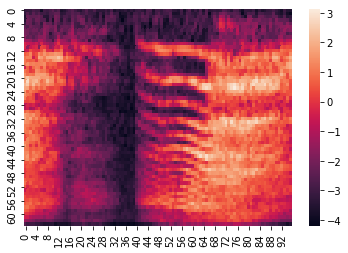

In [8]:
sns.heatmap(features[200].T)

In [9]:
sfreq_2_bands = {
    16000: 64,
    2000: 21,
    1000: 12,
    500: 6,
    250: 3,
    125: 1
}

num_bands = sfreq_2_bands[sfreq]
print(num_bands)

64


In [10]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(labels),
                                            labels)
class_weights = dict(enumerate(weights))
class_name_weights = {np.unique(labels)[key]:class_weights[key] for key in class_weights.keys()}
# class_name_weights

/home/dhruv/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=['alarm-clock' 'baby-cry' 'blender' 'car-horn' 'cat-meow' 'chopping'
 'cooking' 'cough' 'dishwasher' 'dog-bark' 'door' 'doorbell' 'drill'
 'engine' 'flush' 'hair-dryer' 'hammer' 'hazard-alarm' 'knock' 'laugh'
 'microwave' 'phone-ring' 'saw' 'shaver' 'snore' 'speech' 'toothbrush'
 'typing' 'vacuum' 'water-running'], y=['baby-cry' 'baby-cry' 'baby-cry' ... 'cat-meow' 'cat-meow' 'cat-meow'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [11]:
ohe = OneHotEncoder()
labels = ohe.fit_transform(labels.reshape((-1,1))).toarray()

NUM_CLASSES = 30

features = features.reshape((-1, 
                             vggish_params.NUM_FRAMES, 
                             num_bands, 1))

labels = labels.reshape((-1, NUM_CLASSES))
X_train = features
y_train = labels
del features,labels

In [12]:
test_features = pickle.load(open('featurized_data/downsample/X_test_{}.pkl'.format(sfreq), 'rb'))
test_labels = pickle.load(open('featurized_data/downsample/y_test_{}.pkl'.format(sfreq), 'rb'))
test_features = np.concatenate(np.concatenate(test_features))
test_labels = np.concatenate(np.concatenate(test_labels))

test_labels = ohe.transform(test_labels.reshape((-1,1))).toarray()

# NUM_CLASSES = 30

test_features = test_features.reshape((-1, 
                             vggish_params.NUM_FRAMES, 
                             num_bands, 1))

test_labels = test_labels.reshape((-1, NUM_CLASSES))

In [13]:
X_test = test_features
y_test = test_labels
del test_labels, test_features

In [14]:
print('X train shape {}'.format(X_train.shape))
print('X test  shape {}'.format(X_test.shape))
print('y train shape {}'.format(y_train.shape))
print('y test  shape {}'.format(y_test.shape))

X train shape (87395, 96, 64, 1)
X test  shape (26154, 96, 64, 1)
y train shape (87395, 30)
y test  shape (26154, 30)


In [16]:
# Define VGGish, load the checkpoint, and run the batch through the model to
# produce embeddings.
vggish = vggish_keras.get_vggish_keras(use_with_lstm=False, num_bands=num_bands)
# vggish.load_weights(checkpoint_path)

x = vggish.output
x = Dense(NUM_CLASSES, activation='sigmoid', name='prediction')(x)
model = Model(vggish.input, x, name='model')

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', 
              metrics=['accuracy'])

# model.load_weights('checkpoints/model_{}.h5'.format(sfreq))

checkpoint = ModelCheckpoint('checkpoints/model_custom_{}.h5'.format(sfreq), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=0.000001)

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [69]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 12, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 96, 12, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 6, 64)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 6, 128)        73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 24, 3, 128)        0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 24, 3, 256)        295168    
_________________________________________________________________
conv3_2 (Conv2D)             (None, 24, 3, 256)        590080

In [70]:
history = model.fit(X_train, y_train, epochs=100, batch_size=vggish_params.BATCH_SIZE, validation_data=(X_test, y_test),
                    class_weight=class_weights, callbacks= [checkpoint, earlystopping, reducelr], shuffle=True)

Epoch 1/100
1366/1366 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.0686
Epoch 00001: val_accuracy improved from -inf to 0.19462, saving model to checkpoints/model_custom_1000.h5
1366/1366 [==============================] - 24s 18ms/step - loss: 0.1430 - accuracy: 0.0686 - val_loss: 0.1250 - val_accuracy: 0.1946
Epoch 2/100
1365/1366 [============================>.] - ETA: 0s - loss: 0.1167 - accuracy: 0.2451
Epoch 00002: val_accuracy improved from 0.19462 to 0.23308, saving model to checkpoints/model_custom_1000.h5
1366/1366 [==============================] - 24s 17ms/step - loss: 0.1167 - accuracy: 0.2451 - val_loss: 0.1192 - val_accuracy: 0.2331
Epoch 3/100
1365/1366 [============================>.] - ETA: 0s - loss: 0.1032 - accuracy: 0.3568
Epoch 00003: val_accuracy improved from 0.23308 to 0.29617, saving model to checkpoints/model_custom_1000.h5
1366/1366 [==============================] - 24s 18ms/step - loss: 0.1032 - accuracy: 0.3568 - val_loss: 0.11

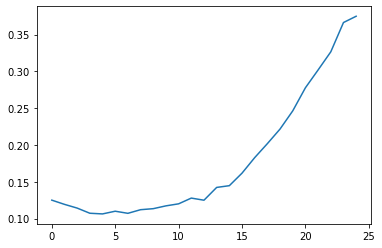

In [71]:
plt.plot(history.history['val_loss'])

### Contextual Results

In [73]:
test_features = pickle.load(open('featurized_data/downsample/X_test_{}.pkl'.format(sfreq), 'rb'))
test_labels = pickle.load(open('featurized_data/downsample/y_test_{}.pkl'.format(sfreq), 'rb'))
# test_features = np.concatenate(np.concatenate(test_features))
# test_labels = np.concatenate(np.concatenate(test_labels))

test_features_flat = []
for cls in test_features:
    for file in cls:
        if len(file) != 0:
            test_features_flat.append(file)

test_labels_ohe = []
for cls in test_labels:
    for file in cls:
        if len(file) != 0:
            file_labels = ohe.transform(np.array(file).reshape((-1,1))).toarray()
            test_labels_ohe.append(file_labels)

NUM_CLASSES = 30

X_test = [file.reshape((-1, vggish_params.NUM_FRAMES, num_bands, 1)) for file in test_features_flat] 
y_test = [file.reshape((-1, NUM_CLASSES)) for file in test_labels_ohe]

In [74]:
sfreq

1000

In [75]:
model.load_weights('checkpoints/model_custom_{}.h5'.format(sfreq))
print('Loaded best checkpoint!')

Loaded best checkpoint!


In [76]:
labels_test = np.array([ohe.inverse_transform(file).flatten() for file in y_test])

In [77]:
pred = np.array([model.predict(file) for file in X_test])

In [16]:
pred_time = []
for file in tqdm(X_test):
    for i in range(len(file)):
        frame = file[i:i+1]
        st = time.time()
        prediction = model.predict(frame)
        en = time.time()
        pred_time.append(en-st)

100%|██████████| 1546/1546 [10:15<00:00,  2.51it/s]


In [17]:
print('{},{}'.format(sfreq, np.mean(pred_time)))

125,0.018664759476043406


In [78]:
encoding = {label: ohe.transform(np.array(label).reshape(-1,1)).toarray() for label in np.unique(np.concatenate(labels_test).flatten())}

contexts = {
    'monolithic': ['alarm-clock', 'baby-cry', 'blender', 'car-horn', 'cat-meow',
       'chopping', 'cooking', 'cough', 'dishwasher', 'dog-bark', 'door',
       'doorbell', 'drill', 'engine', 'flush', 'hair-dryer', 'hammer',
       'hazard-alarm', 'knock', 'laugh', 'microwave', 'phone-ring', 'saw',
       'shaver', 'snore', 'speech', 'toothbrush', 'typing', 'vacuum',
       'water-running'],
    'bathroom': ['water-running', 'shaver', 'toothbrush', 'flush', 'hair-dryer'],
    'kitchen': ['hazard-alarm', 'speech', 'chopping', 'water-running', 'microwave', 'blender', 'dishwasher', 'cooking'],
    'bedroom': ['speech', 'baby-cry', 'cough', 'snore', 'alarm-clock'],
    'office': ['phone-ring', 'speech', 'cough', 'door', 'knock', 'typing'],
    'entrance': ['speech', 'door', 'knock', 'doorbell', 'laugh'],
    'workshop': ['drill', 'hazard-alarm', 'speech', 'vacuum', 'hammer', 'saw'],
    'outdoor': ['dog-bark', 'hazard-alarm', 'speech', 'car-horn', 'engine', 'cat-meow']
}

context_encoding = {}
for context in contexts.keys():
    context_encoding[context] = np.zeros((1,30))
    for activity in contexts[context]:
        context_encoding[context] += encoding[activity]    

1000,monolithic,0.5160190865712339,0.5092795835534998
1000,bathroom,0.697508896797153,0.6923295509031459
1000,kitchen,0.6318181818181818,0.6214383282878412
1000,bedroom,0.6852589641434262,0.6820018708816087
1000,office,0.8072289156626506,0.80678144559412
1000,entrance,0.6812749003984063,0.6806524002655413
1000,workshop,0.6834532374100719,0.6898709008643132
1000,outdoor,0.6690909090909091,0.6596463358859096


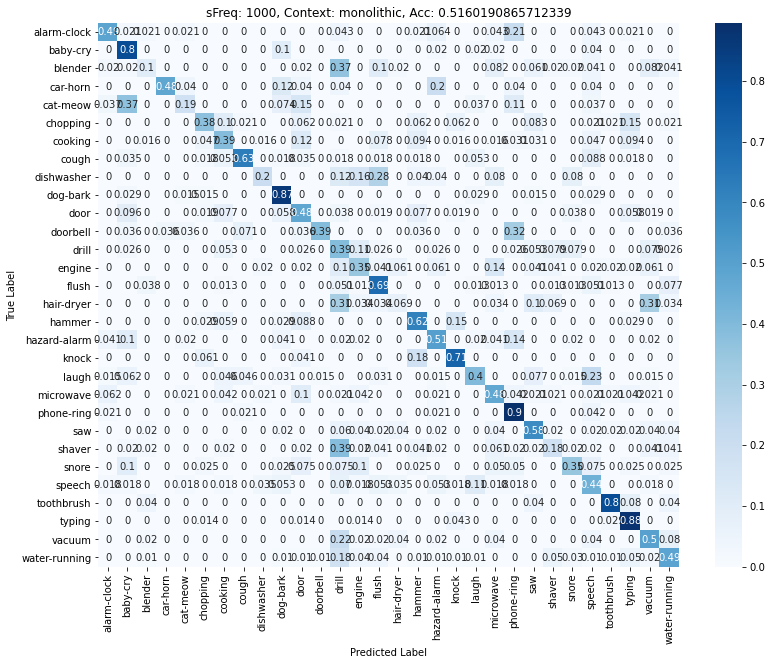

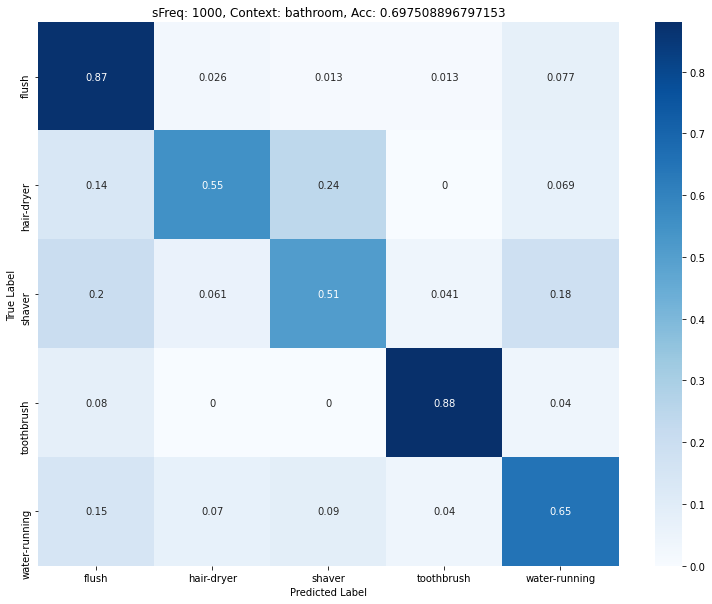

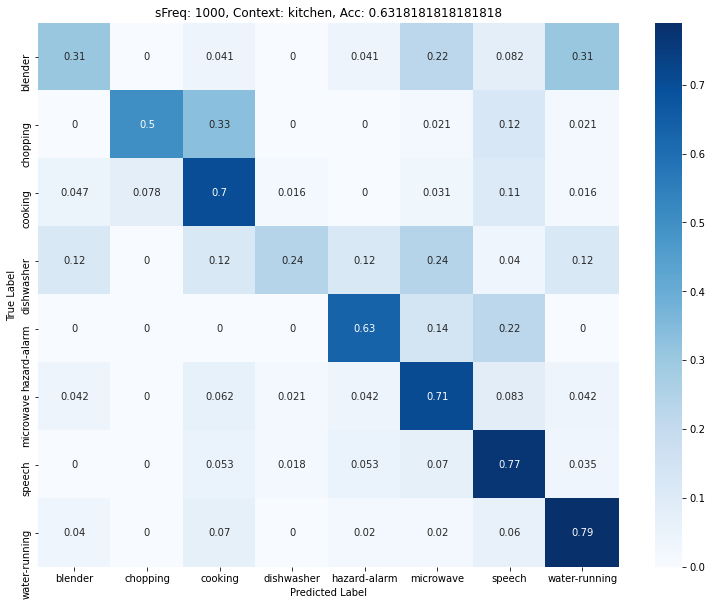

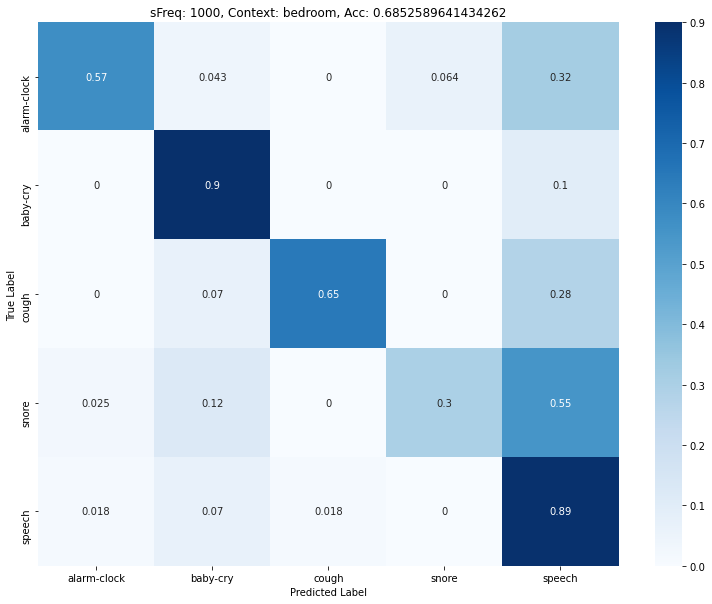

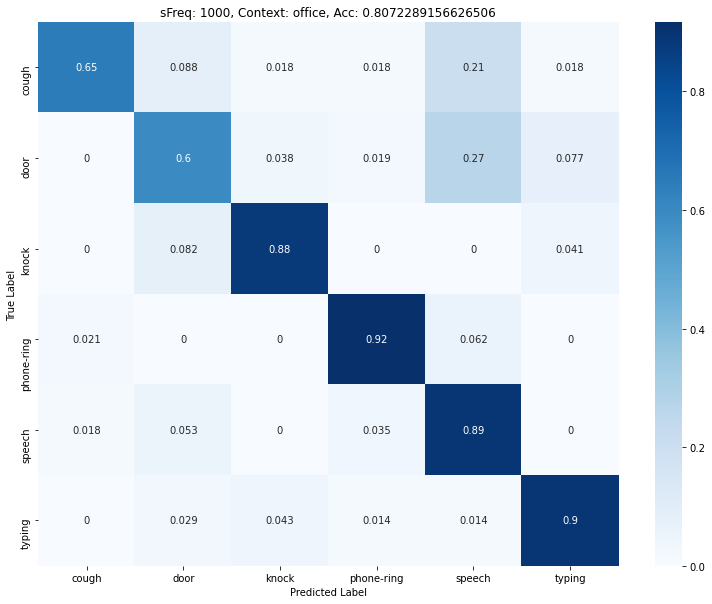

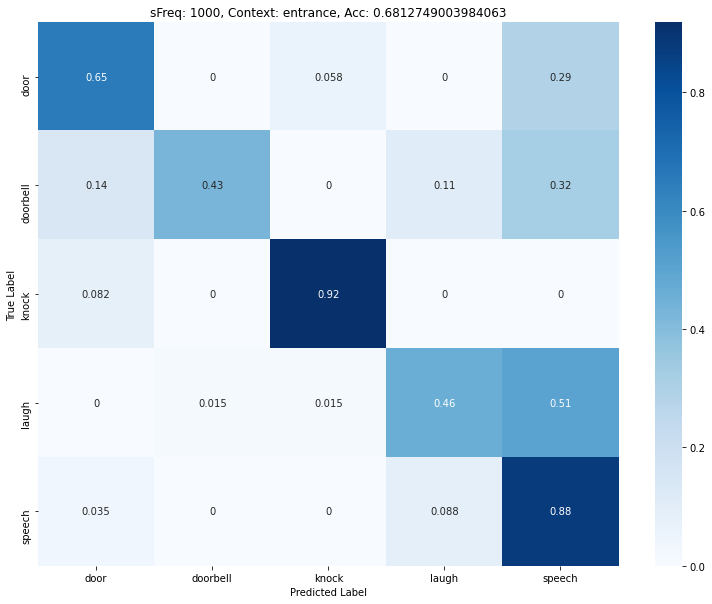

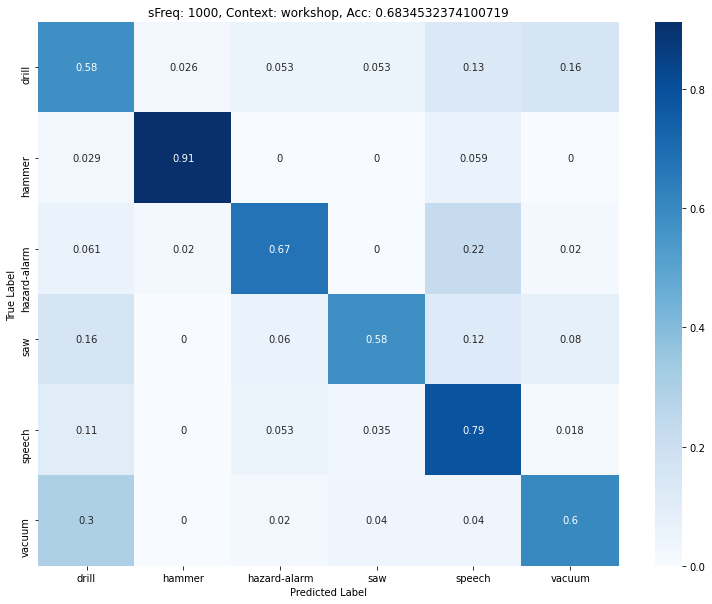

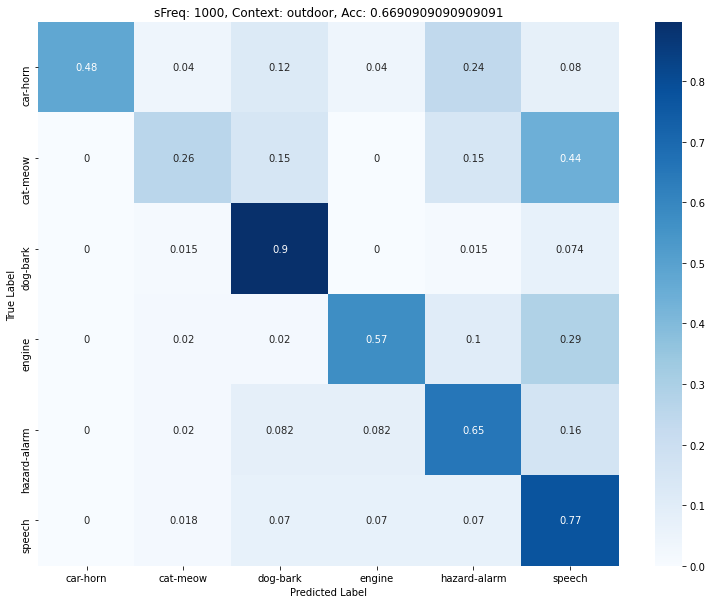

In [81]:
for context in contexts.keys():
#     context = list(contexts.keys())[1]
    valid_idx = [i for i, label in enumerate(labels_test) if label[0] in contexts[context]]
    valid_pred = pred[valid_idx]
    valid_labels = labels_test[valid_idx]
    valid_pred = [np.argmax(file * context_encoding[context], axis=1) for file in valid_pred]
    # Transform to per file level labels
    valid_pred = [ohe.categories_[0][mode(file)] for file in valid_pred]
    valid_labels = [file[0] for file in valid_labels]
    acc = accuracy_score(valid_labels, valid_pred)
    f1 = f1_score(valid_labels, valid_pred, average='weighted')
    conf_mat = confusion_matrix(valid_labels, valid_pred, normalize='true')
    label_names = np.unique(valid_labels)
    print('{},{},{},{}'.format(sfreq, context, acc, f1))
    fig, ax = plt.subplots(figsize=(13,10))
    sns.heatmap(conf_mat, cmap='Blues', ax=ax, xticklabels=label_names, yticklabels=label_names, annot=True)
    ax.set_title('sFreq: {}, Context: {}, Acc: {}'.format(sfreq,context,acc))
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')